## Data Cleansing and Refinement Report (AmazonProject-ML3.3)

### 1. Initial Data Loading

The dataset best_dataset_clean_2.1.pkl was loaded.
A column summary was created, including data types, number of missing values, and number of unique entries.

### 2. Identification of Continuous Variables

Numeric columns (int64, float64) were selected into continuous_df,
and all were converted to float64 for computational consistency.

### 3. Graphical Analysis – Boxplots

Boxplots were generated for each numeric variable to identify outliers.
These visualizations help detect overly wide ranges or abnormal distributions.

### 4. Outlier Detection and Treatment

An Interquartile Range (IQR) analysis was performed on the main numeric columns
(amount, gross_amt, stock, unit_price).

Definitions:

* Outliers = 1, Normal values = 0

Tests applied:

* KS test – checks for distribution change
* Point-Biserial correlation – checks for correlation change with the target variable

Columns showing a change in distribution but no change in correlation were marked for removal.

### 5. Actual Outlier Cleaning

Outlier values were replaced with NaN in a clean copy of the dataset (df_cleaned).
The cleaned version was saved as df_cleaned.pkl.

### 6. Missing-Value Analysis

A missing-value matrix was generated using missingno.matrix.
Only columns with actual missing values were displayed, and the percentage of missingness was calculated for each.

### 7. Missing-Value Imputation (MICE)

Missing numerical values were imputed using the IterativeImputer from scikit-learn.
This method applies multiple regression models to estimate missing data with high accuracy.
Negative values produced by rounding or estimation were clipped to zero to avoid anomalies.

### 8. Filling Missing Categorical, Text, and Boolean Data

Categorical columns: added a new category "unknown".
String columns: missing entries filled with "unknown".
Boolean columns: missing entries filled with False.

### 9. Final Cleaning of the Target Variable – status

Rows where status == 'unknown' were removed, and the unused category was dropped.
A final validation confirmed that no missing values remained.

### 10. Saving the Updated Data

The final cleaned dataset was saved as final_df.ML3.3.pkl.

### Final Outcome

The file final_df.ML3.3.pkl represents a clean, balanced, and outlier-free version of Amazon India’s sales data,
fully prepared for the machine learning phase.


# Data Cleansing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import pandas as pd
df = pd.read_pickle("best_dataset_clean_2.1.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  129002 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  129002 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   129001 non-null  category      
 7   currency              121204 non-null  string        
 8   amount                121204 non-null  float64       
 9   ship-state            128969 non-null  string        
 10  ship-postal-code      128969 non-null  Int64         
 11  ship-country          128969 non-null  category      
 12  b2b                   129002 non-null  boolean       
 13  day 

In [ ]:
df

,date,fulfilment,ship-service-level,category,size,asin,pcs,currency,amount,ship-state,...,status,fulfilment_by_amazon,amazon_channel,ship-city_norm,has_promotion,seller_easy_ship,category_stock_norm,color_norm,season,unit_price
0,2022-03-31,Merchant,Standard,Western Dress,M,B09SDY8DCT,1,INR,761.0,TAMIL NADU,...,Shipped,False,True,CHENNAI,True,True,KURTA,Green,Summer,761.0
1,2022-03-31,Merchant,Expedited,Set,M,B099NDNDD4,1,INR,519.0,KARNATAKA,...,Shipped,True,True,BENGALURU,True,False,SET,Cream,Summer,519.0
2,2022-03-31,Merchant,Expedited,Set,S,B09QJ577FG,1,INR,1165.0,MAHARASHTRA,...,Shipped,True,True,BHIWANDI,True,False,SET,Pink,Summer,1165.0
3,2022-03-31,Merchant,Expedited,kurta,L,B08N19RF53,1,INR,358.0,BIHAR,...,Shipped,True,True,PATNA,False,False,KURTA,Orange,Summer,358.0
4,2022-03-31,Merchant,Expedited,kurta,XXL,B08TH4GTW9,1,INR,417.0,GUJARAT,...,Shipped,True,True,VADODARA,True,False,KURTA,Maroon,Summer,417.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130421,2022-06-29,Merchant,Expedited,kurta,XL,B09TH43WCQ,1,INR,399.0,KARNATAKA,...,Shipped,True,True,BENGALURU,False,False,KURTA,Maroon,Monsoon,399.0
130422,2022-06-29,Merchant,Expedited,Set,XL,B08HK5C45Z,0,INR,668.0,KARNATAKA,...,Pending,True,True,BANGALORE,False,False,SET,Red,Monsoon,inf
130423,2022-06-29,Merchant,Expedited,Set,S,B07Q2M4W2P,1,INR,612.0,BIHAR,...,Shipped,True,True,PATNA,True,False,SET,Mustard,Monsoon,612.0
130424,2022-06-29,Merchant,Expedited,kurta,XL,B099NM4XNX,0,INR,301.0,UTTAR PRADESH,...,Pending,True,True,OTHER,False,False,KURTA,Green,Monsoon,inf


In [ ]:
# Build a summary table with information about all columns
summary = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes.values,
    "Null Count": df.isnull().sum().values,
    "Unique Count": df.nunique().values
})

#display(summary.style.background_gradient(cmap="Blues"))

print(summary.to_markdown(index=False))

| Column               | Data Type      |   Null Count |   Unique Count |
|:---------------------|:---------------|-------------:|---------------:|
| date                 | datetime64[ns] |            0 |             91 |
| fulfilment           | category       |            0 |              1 |
| ship-service-level   | category       |            0 |              2 |
| category             | category       |            0 |              4 |
| size                 | category       |            0 |              9 |
| asin                 | string         |            0 |           7190 |
| pcs                  | category       |            1 |              6 |
| currency             | string         |         7798 |              1 |
| amount               | float64        |         7798 |           1410 |
| ship-state           | string         |           33 |             47 |
| ship-postal-code     | Int64          |           33 |           9459 |
| ship-country         | category     

Creating a continuous_df for continuous values

In [ ]:
# Selecting only numeric continuous columns (excluding categorical and discrete)
# In most cases, continuous variables are numeric and float types
continuous_df = df.select_dtypes(include=['float64', 'int64'])
continuous_df = continuous_df.astype({col: 'float64' for col in continuous_df.select_dtypes(include='int64').columns})

# Display the small dataset with only numeric continuous data
continuous_df

,amount,ship-postal-code,day,stock,unit_price
0,761.0,600026.0,31.0,6.0,761.0
1,519.0,560085.0,31.0,1.0,519.0
2,1165.0,421302.0,31.0,11.0,1165.0
3,358.0,800013.0,31.0,2.0,358.0
4,417.0,390002.0,31.0,281.0,417.0
...,...,...,...,...,...
130421,399.0,560016.0,29.0,16.0,399.0
130422,668.0,560085.0,29.0,40.0,inf
130423,612.0,800002.0,29.0,9.0,612.0
130424,301.0,201102.0,29.0,69.0,inf


continuous numbers df

In [ ]:
continuous_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   amount            121204 non-null  float64
 1   ship-postal-code  128969 non-null  float64
 2   day               129002 non-null  float64
 3   stock             128781 non-null  float64
 4   unit_price        121178 non-null  float64
dtypes: float64(5)
memory usage: 5.9 MB


#Numeric columns Value Boxplot

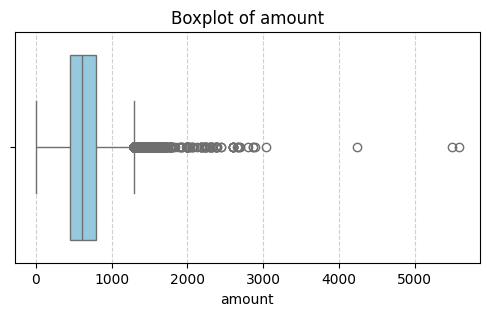

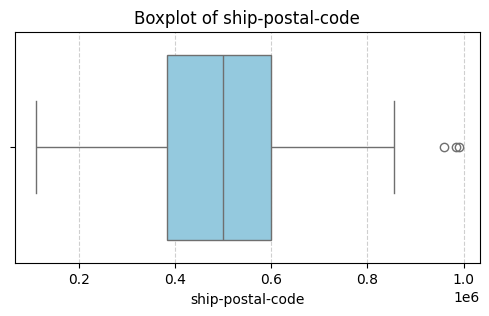

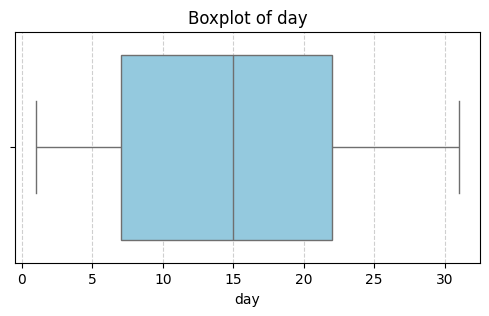

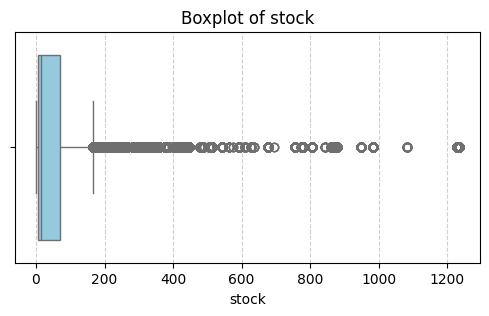

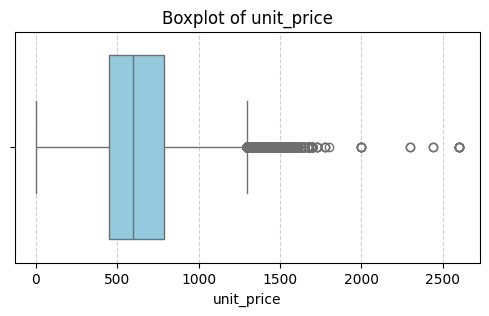

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Select all numeric columns ===
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# === Step 2: Iterate over each numeric column and create a Boxplot ===
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}", fontsize=12)
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


# Outliers

In [ ]:
cols = ['amount', 'gross_amt', 'stock', 'unit_price']
continuous_df_log = df[[c for c in cols if c in df.columns]]
print("Columns used:", list(continuous_df_log.columns))


Columns used: ['amount', 'stock', 'unit_price']


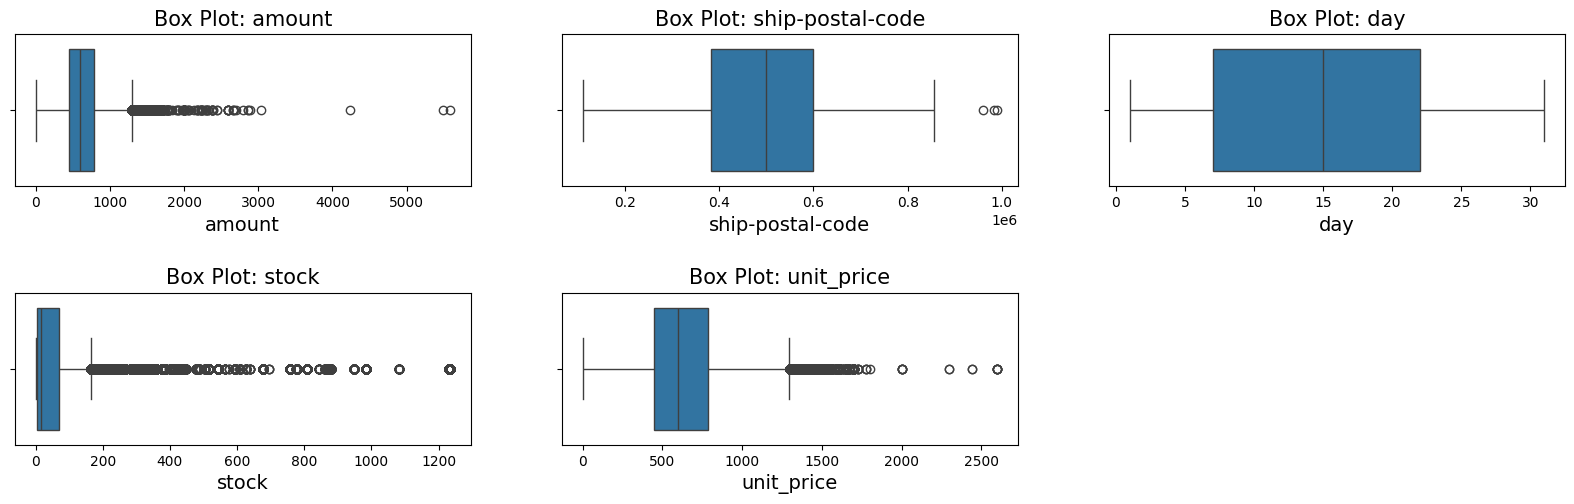

In [ ]:
# Define the function to plot box plots for each numeric column
def outliers_boxplot(df):
    plt.figure(figsize=(20, 200))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(60, 3, i + 1)
        sns.boxplot(data=df, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(f'{col}', fontsize=14)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

# Assuming con_df contains the continuous numeric columns
outliers_boxplot(continuous_df)

### IQR Outliers

In [ ]:
# Function to identify outliers using IQR on LOG-transformed data
def treat_outliers(continuous_df_log, features):
    outliers_df = pd.DataFrame(index=continuous_df_log.index)
    for feature in features:
        Q1 = continuous_df_log[feature].quantile(0.25)
        Q3 = continuous_df_log[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_df[feature] = ((continuous_df_log[feature] < lower_bound) |
                                (continuous_df_log[feature] > upper_bound)).astype(int)
    return outliers_df

# Apply the outlier treatment function to numeric columns
outliers_df = treat_outliers(continuous_df_log, continuous_df_log.columns)

# Display the table
outliers_df


,amount,stock,unit_price
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,1,0
...,...,...,...
130421,0,0,0
130422,0,0,1
130423,0,0,0
130424,0,0,1


In [ ]:
#Creating a table for outliers change
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed


In [ ]:
from scipy.stats import pointbiserialr, ks_2samp
import numpy as np
import pandas as pd

# Replace inf / -inf with NaN in the continuous data
continuous_df_log = continuous_df_log.replace([np.inf, -np.inf], np.nan)


THRESHOLD = 0.05  # "Significant" change in correlation
rows = []
# Convert the 'status' column to a binary value (1/0)
status_num = df['status'].map({'Shipped': 1, 'Pending': 0})

# Find common columns
common_cols = list(set(continuous_df_log.columns) & set(outliers_df.columns))

def safe_pbiserial(x: np.ndarray, y: np.ndarray) -> float:
    """Safely compute point-biserial correlation between a continuous variable (x) and a binary target (y)."""
    mask = ~np.isnan(x) & ~np.isnan(y)  # remove NaN values
    x = x[mask]
    y = y[mask]
    if x.size < 3:  # not enough data points
        return np.nan
    uy = np.unique(y)
    if uy.size != 2:  # ensure y has exactly two classes
        return np.nan
    if np.nanstd(x) == 0:  # avoid division by zero if x is constant
        return np.nan
    r, _p = pointbiserialr(x, y)
    return r

for col in common_cols:
    # Convert current column to numeric values
    x_all = pd.to_numeric(continuous_df_log[col], errors='coerce')

    # Define masks for outliers and non-outliers
    mask_outlier_flag = (outliers_df[col].fillna(0) == 1)
    mask_non_outlier  = (outliers_df[col].fillna(0) == 0)

    # Target variable (status)
    y_all = status_num

    # Valid masks
    mask_all_valid = x_all.notna() & y_all.notna()
    mask_non_valid = mask_all_valid & mask_non_outlier

    # --- point-biserial correlation ---
    r_all = safe_pbiserial(x_all[mask_all_valid].to_numpy(),
                           y_all[mask_all_valid].to_numpy())
    r_non = safe_pbiserial(x_all[mask_non_valid].to_numpy(),
                           y_all[mask_non_valid].to_numpy())

    # Determine whether correlation changed significantly
    if np.isnan(r_all) or np.isnan(r_non):
        cor_change = '-'
    else:
        cor_change = '+' if abs(r_all - r_non) > THRESHOLD else '-'

    # --- KS test for distribution change ---
    x_with_outliers    = x_all[mask_outlier_flag].dropna()
    x_without_outliers = x_all[mask_non_outlier].dropna()
    if (len(x_with_outliers) >= 2) and (len(x_without_outliers) >= 2):
        ks_p = ks_2samp(x_with_outliers, x_without_outliers).pvalue
        dist_change = '+' if ks_p < 0.05 else '-'
    else:
        dist_change = '-'

    # Append feature results
    rows.append({
        'feature': col,
        'outliers_cnt': int(outliers_df[col].fillna(0).sum()),
        'distribution_changed': dist_change,
        'correlation_changed': cor_change
    })

# Create results DataFrame and sort by significance
out_df = pd.DataFrame(rows).sort_values(
    ['distribution_changed', 'correlation_changed', 'outliers_cnt'],
    ascending=[False, False, False]
).reset_index(drop=True)

print(out_df)


      feature  outliers_cnt distribution_changed correlation_changed
0       stock         14054                    +                   -
1  unit_price         11999                    +                   -
2      amount          3600                    +                   -


In [ ]:
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed
0,stock,14054,+,-
1,unit_price,11999,+,-
2,amount,3600,+,-


In [ ]:
# Add the 'drop' column based on the specified conditions
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')

# Filter features where only distribution changes but not correlation
to_drop = out_df[out_df['drop'] == 'yes']['feature']

# Display the resulting DataFrame
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,stock,14054,+,-,yes
1,unit_price,11999,+,-,yes
2,amount,3600,+,-,yes


In [ ]:
to_drop

,feature
0,stock
1,unit_price
2,amount


Remove Outliers

In [ ]:
# Build the drop list (exclude target 'popularity')
to_drop = out_df.loc[(out_df['drop'] == 'yes') & (out_df['feature'] != 'status'), 'feature'].tolist()

# Remove outliers (cell-wise) only for the selected features
df_cleaned = df.copy()
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan
    # keep log frame in sync if exists
    if col in continuous_df_log.columns:
        continuous_df_log.loc[outliers_df[col] == 1, col] = np.nan

# Display the updated df_cleaned
df_cleaned

,date,fulfilment,ship-service-level,category,size,asin,pcs,currency,amount,ship-state,...,status,fulfilment_by_amazon,amazon_channel,ship-city_norm,has_promotion,seller_easy_ship,category_stock_norm,color_norm,season,unit_price
0,2022-03-31,Merchant,Standard,Western Dress,M,B09SDY8DCT,1,INR,761.0,TAMIL NADU,...,Shipped,False,True,CHENNAI,True,True,KURTA,Green,Summer,761.0
1,2022-03-31,Merchant,Expedited,Set,M,B099NDNDD4,1,INR,519.0,KARNATAKA,...,Shipped,True,True,BENGALURU,True,False,SET,Cream,Summer,519.0
2,2022-03-31,Merchant,Expedited,Set,S,B09QJ577FG,1,INR,1165.0,MAHARASHTRA,...,Shipped,True,True,BHIWANDI,True,False,SET,Pink,Summer,1165.0
3,2022-03-31,Merchant,Expedited,kurta,L,B08N19RF53,1,INR,358.0,BIHAR,...,Shipped,True,True,PATNA,False,False,KURTA,Orange,Summer,358.0
4,2022-03-31,Merchant,Expedited,kurta,XXL,B08TH4GTW9,1,INR,417.0,GUJARAT,...,Shipped,True,True,VADODARA,True,False,KURTA,Maroon,Summer,417.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130421,2022-06-29,Merchant,Expedited,kurta,XL,B09TH43WCQ,1,INR,399.0,KARNATAKA,...,Shipped,True,True,BENGALURU,False,False,KURTA,Maroon,Monsoon,399.0
130422,2022-06-29,Merchant,Expedited,Set,XL,B08HK5C45Z,0,INR,668.0,KARNATAKA,...,Pending,True,True,BANGALORE,False,False,SET,Red,Monsoon,NaN
130423,2022-06-29,Merchant,Expedited,Set,S,B07Q2M4W2P,1,INR,612.0,BIHAR,...,Shipped,True,True,PATNA,True,False,SET,Mustard,Monsoon,612.0
130424,2022-06-29,Merchant,Expedited,kurta,XL,B099NM4XNX,0,INR,301.0,UTTAR PRADESH,...,Pending,True,True,OTHER,False,False,KURTA,Green,Monsoon,NaN


In [ ]:
# Save cleaned data
df_cleaned.to_pickle('df_cleaned.pkl')

# Missing Values

Now we use df_cleaned

<Axes: >

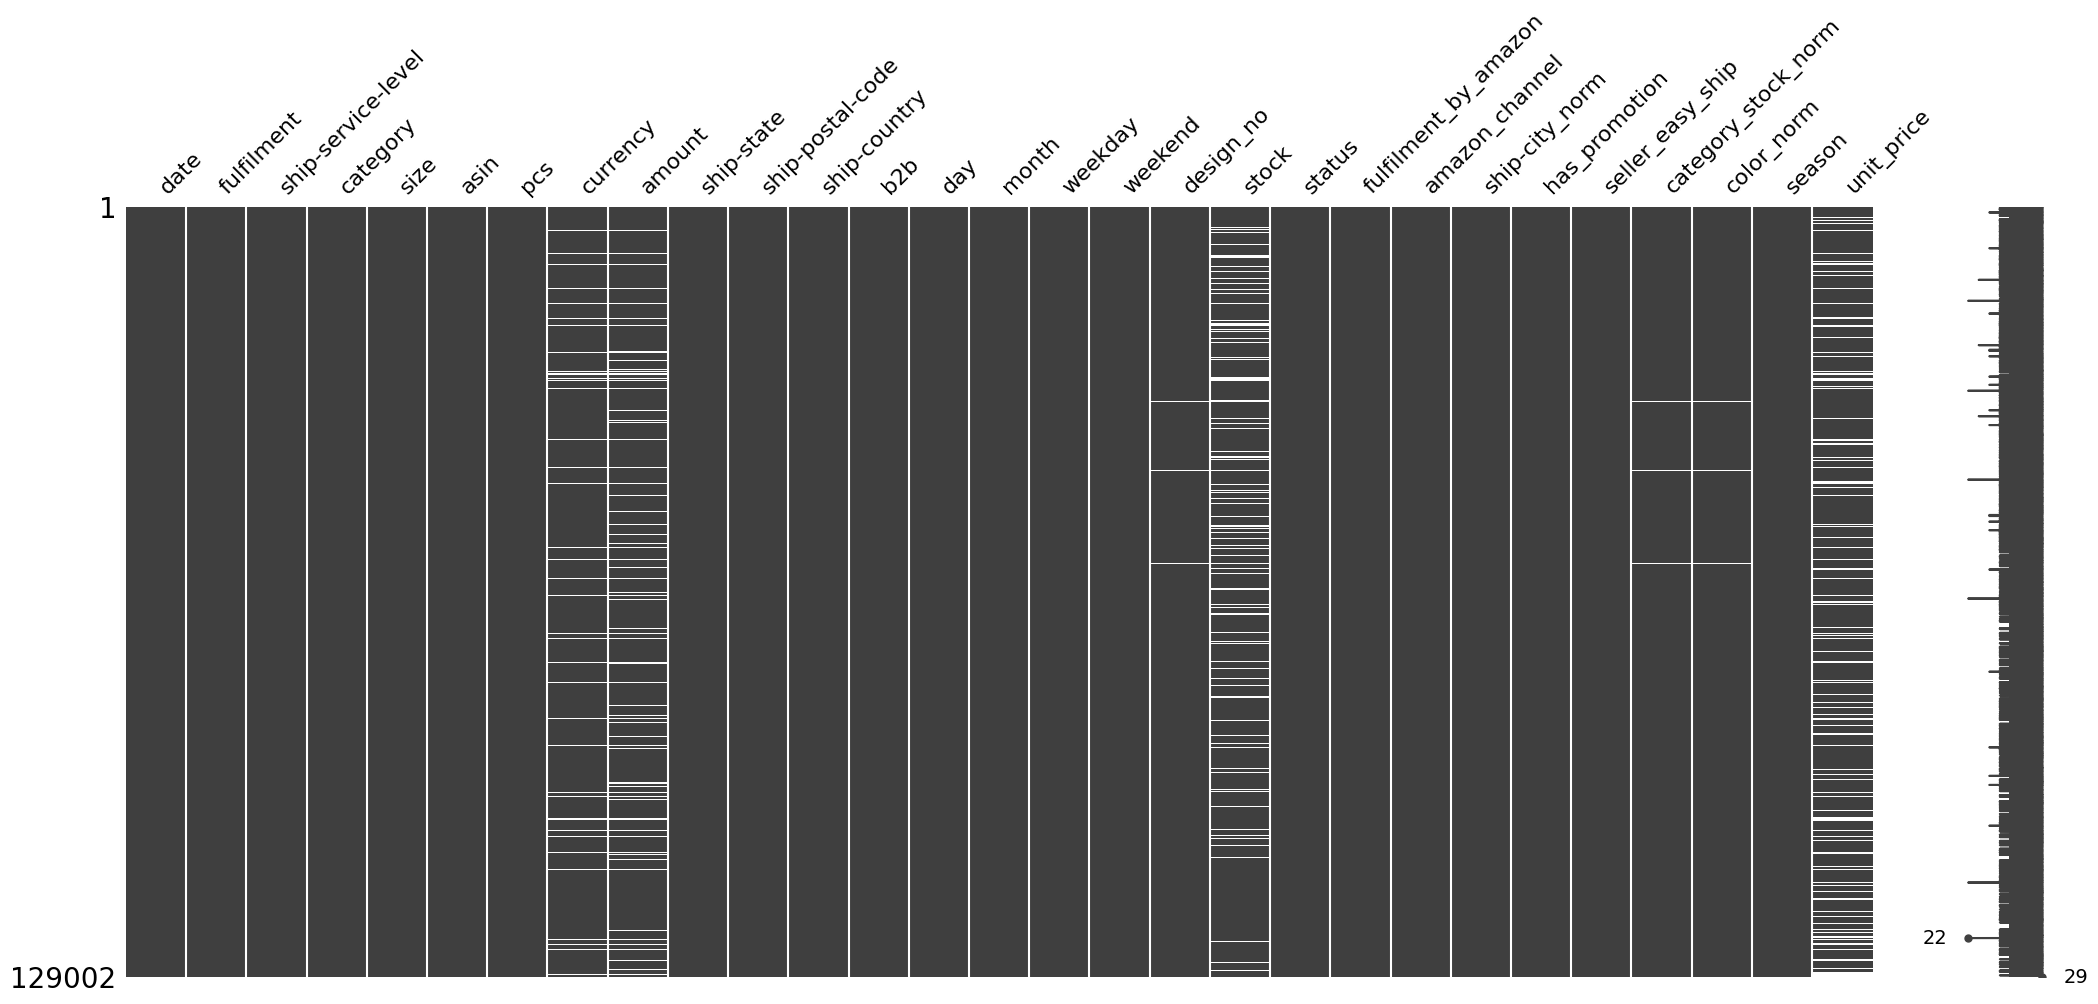

In [ ]:
import missingno as msno
msno.matrix(df_cleaned)

In [ ]:
# Create a copy of the cleaned DataFrame
df_nulls = df_cleaned.copy()

# Iterate through all columns and remove those without missing values
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]

# Display only columns that contain missing (NaN) values
df_nulls


,pcs,currency,amount,ship-state,ship-postal-code,ship-country,design_no,stock,ship-city_norm,category_stock_norm,color_norm,unit_price
0,1,INR,761.0,TAMIL NADU,600026,IN,JNE3797,6.0,CHENNAI,KURTA,Green,761.0
1,1,INR,519.0,KARNATAKA,560085,IN,J0345,1.0,BENGALURU,SET,Cream,519.0
2,1,INR,1165.0,MAHARASHTRA,421302,IN,SET366,11.0,BHIWANDI,SET,Pink,1165.0
3,1,INR,358.0,BIHAR,800013,IN,J0132,2.0,PATNA,KURTA,Orange,358.0
4,1,INR,417.0,GUJARAT,390002,IN,JNE3607,NaN,VADODARA,KURTA,Maroon,417.0
...,...,...,...,...,...,...,...,...,...,...,...,...
130421,1,INR,399.0,KARNATAKA,560016,IN,JNE3878,16.0,BENGALURU,KURTA,Maroon,399.0
130422,0,INR,668.0,KARNATAKA,560085,IN,SET196,40.0,BANGALORE,SET,Red,NaN
130423,1,INR,612.0,BIHAR,800002,IN,SET044,9.0,PATNA,SET,Mustard,612.0
130424,0,INR,301.0,UTTAR PRADESH,201102,IN,JNE3761,69.0,OTHER,KURTA,Green,NaN


Missing Value precentage

In [ ]:
# Calculate the percentage of missing values in each column
missing_percentage = df_nulls.isnull().mean() * 100

# Display the missing percentages
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['Column', 'Missing Percentage']
missing_percentage

,Column,Missing Percentage
0,pcs,0.000775
1,currency,6.044868
2,amount,8.835522
3,ship-state,0.025581
4,ship-postal-code,0.025581
5,ship-country,0.025581
6,design_no,0.171315
7,stock,11.065720
8,ship-city_norm,0.028682
9,category_stock_norm,0.174416


# Imputation with MICE

In [ ]:
# Import IterativeImputer (experimental feature) from scikit-learn
from sklearn.experimental import enable_iterative_imputer  # enables the experimental imputer
from sklearn.impute import IterativeImputer

# Create a copy of the cleaned DataFrame for imputation
final_df = df_cleaned.copy()

# Select only numeric columns (float64 and int64 types) for imputation
imp_cols = final_df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the IterativeImputer (uses multivariate regression to estimate missing values)
imputer = IterativeImputer(max_iter=10, random_state=42, min_value=0)

# Apply imputation on numeric columns
final_df[imp_cols] = imputer.fit_transform(final_df[imp_cols])

# Optional safety step: ensure no small negative values remain due to rounding or estimation errors
final_df[imp_cols] = final_df[imp_cols].clip(lower=0)


In [ ]:
final_df

,date,fulfilment,ship-service-level,category,size,asin,pcs,currency,amount,ship-state,...,status,fulfilment_by_amazon,amazon_channel,ship-city_norm,has_promotion,seller_easy_ship,category_stock_norm,color_norm,season,unit_price
0,2022-03-31,Merchant,Standard,Western Dress,M,B09SDY8DCT,1,INR,761.0,TAMIL NADU,...,Shipped,False,True,CHENNAI,True,True,KURTA,Green,Summer,761.000000
1,2022-03-31,Merchant,Expedited,Set,M,B099NDNDD4,1,INR,519.0,KARNATAKA,...,Shipped,True,True,BENGALURU,True,False,SET,Cream,Summer,519.000000
2,2022-03-31,Merchant,Expedited,Set,S,B09QJ577FG,1,INR,1165.0,MAHARASHTRA,...,Shipped,True,True,BHIWANDI,True,False,SET,Pink,Summer,1165.000000
3,2022-03-31,Merchant,Expedited,kurta,L,B08N19RF53,1,INR,358.0,BIHAR,...,Shipped,True,True,PATNA,False,False,KURTA,Orange,Summer,358.000000
4,2022-03-31,Merchant,Expedited,kurta,XXL,B08TH4GTW9,1,INR,417.0,GUJARAT,...,Shipped,True,True,VADODARA,True,False,KURTA,Maroon,Summer,417.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130421,2022-06-29,Merchant,Expedited,kurta,XL,B09TH43WCQ,1,INR,399.0,KARNATAKA,...,Shipped,True,True,BENGALURU,False,False,KURTA,Maroon,Monsoon,399.000000
130422,2022-06-29,Merchant,Expedited,Set,XL,B08HK5C45Z,0,INR,668.0,KARNATAKA,...,Pending,True,True,BANGALORE,False,False,SET,Red,Monsoon,667.063340
130423,2022-06-29,Merchant,Expedited,Set,S,B07Q2M4W2P,1,INR,612.0,BIHAR,...,Shipped,True,True,PATNA,True,False,SET,Mustard,Monsoon,612.000000
130424,2022-06-29,Merchant,Expedited,kurta,XL,B099NM4XNX,0,INR,301.0,UTTAR PRADESH,...,Pending,True,True,OTHER,False,False,KURTA,Green,Monsoon,301.764226


#Checking at the updated missing matrix

<Axes: >

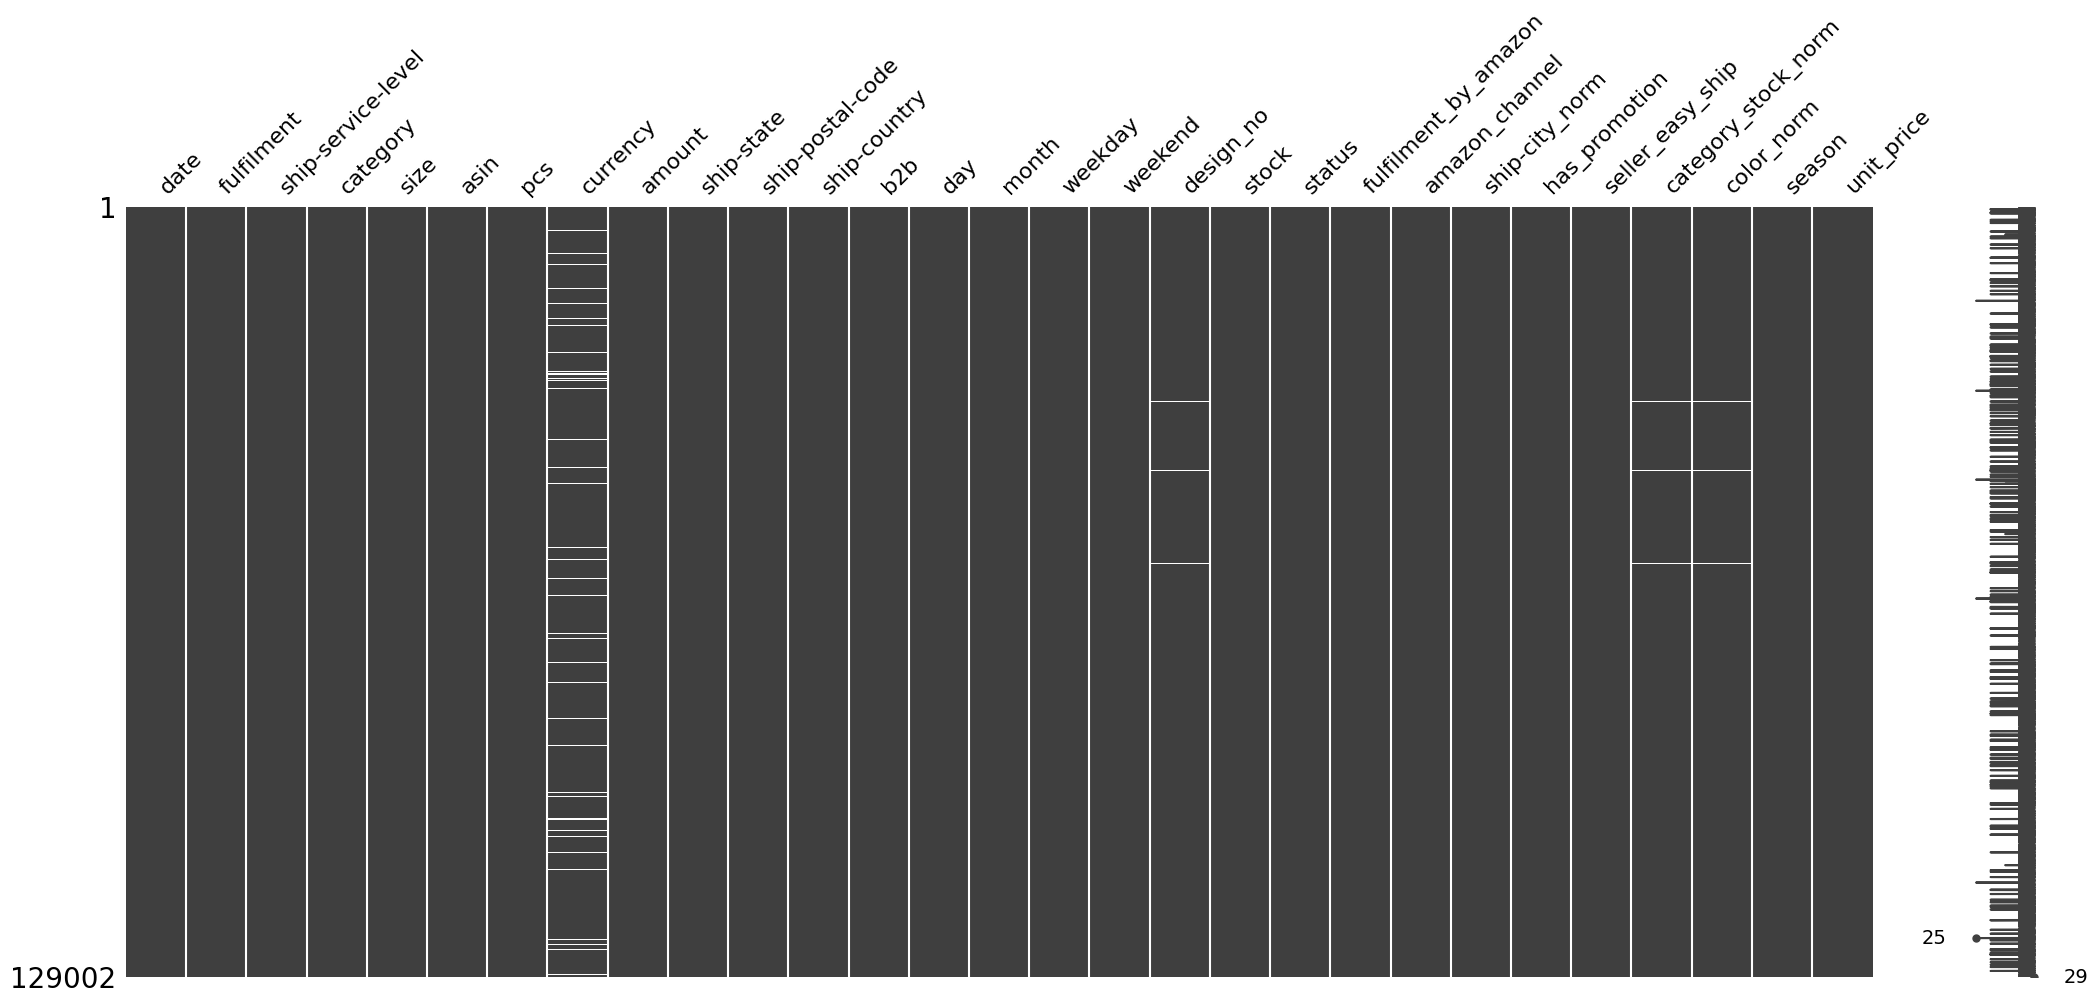

In [ ]:
msno.matrix(final_df)

In [ ]:
#Duable checking the cleansing
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  129002 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  129002 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   129001 non-null  category      
 7   currency              121204 non-null  string        
 8   amount                129002 non-null  float64       
 9   ship-state            128969 non-null  string        
 10  ship-postal-code      129002 non-null  float64       
 11  ship-country          128969 non-null  category      
 12  b2b                   129002 non-null  boolean       
 13  day 

In [ ]:
# 1. Identify column types
cat_cols   = final_df.select_dtypes(include=['category']).columns     # categorical columns
str_cols   = final_df.select_dtypes(include=['object', 'string']).columns  # string/text columns
bool_cols  = final_df.select_dtypes(include=['bool', 'boolean']).columns   # boolean columns

# 2. Add 'unknown' category to each categorical column (before fillna)
for col in cat_cols:
    if "unknown" not in final_df[col].cat.categories:  # check if 'unknown' exists
        final_df[col] = final_df[col].cat.add_categories("unknown")  # add 'unknown' category
    final_df[col] = final_df[col].fillna("unknown")  # replace NaN with 'unknown'

# 3. Fill missing values in string columns with 'unknown'
final_df[str_cols] = final_df[str_cols].fillna("unknown")

# 4. Fill missing values in boolean columns with False
final_df[bool_cols] = final_df[bool_cols].fillna(False)

# 5. Quick check for remaining missing values
print("\nNulls after filling:")
print(final_df.isna().sum().sort_values(ascending=False).head(10))



Nulls after filling:
date                  0
fulfilment            0
ship-service-level    0
category              0
size                  0
asin                  0
pcs                   0
currency              0
amount                0
ship-state            0
dtype: int64


In [ ]:
# Build a summary table with information about all columns
summary = pd.DataFrame({
    "Column": final_df.columns,
    "Data Type": final_df.dtypes.values,
    "Null Count": final_df.isnull().sum().values,
    "Unique Count": final_df.nunique().values
})

#display(summary.style.background_gradient(cmap="Blues"))

print(summary.to_markdown(index=False))

| Column               | Data Type      |   Null Count |   Unique Count |
|:---------------------|:---------------|-------------:|---------------:|
| date                 | datetime64[ns] |            0 |             91 |
| fulfilment           | category       |            0 |              1 |
| ship-service-level   | category       |            0 |              2 |
| category             | category       |            0 |              4 |
| size                 | category       |            0 |              9 |
| asin                 | string         |            0 |           7190 |
| pcs                  | category       |            0 |              7 |
| currency             | string         |            0 |              2 |
| amount               | float64        |            0 |          12100 |
| ship-state           | string         |            0 |             48 |
| ship-postal-code     | float64        |            0 |           9491 |
| ship-country         | category     

#Remove all rows with 'unknown' values in the target status column.

---



In [ ]:
final_df.status.value_counts()

,count
status,
Shipped,128063
Pending,939
unknown,0


In [ ]:
final_df = final_df[final_df['status'] != 'unknown'].copy()
#Drop 'unknown' category frome status
final_df['status'] = final_df['status'].cat.remove_unused_categories()
final_df.status.value_counts()

,count
status,
Shipped,128063
Pending,939


In [ ]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  129002 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  129002 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   129002 non-null  category      
 7   currency              129002 non-null  string        
 8   amount                129002 non-null  float64       
 9   ship-state            129002 non-null  string        
 10  ship-postal-code      129002 non-null  float64       
 11  ship-country          129002 non-null  category      
 12  b2b                   129002 non-null  boolean       
 13  day 

<Axes: >

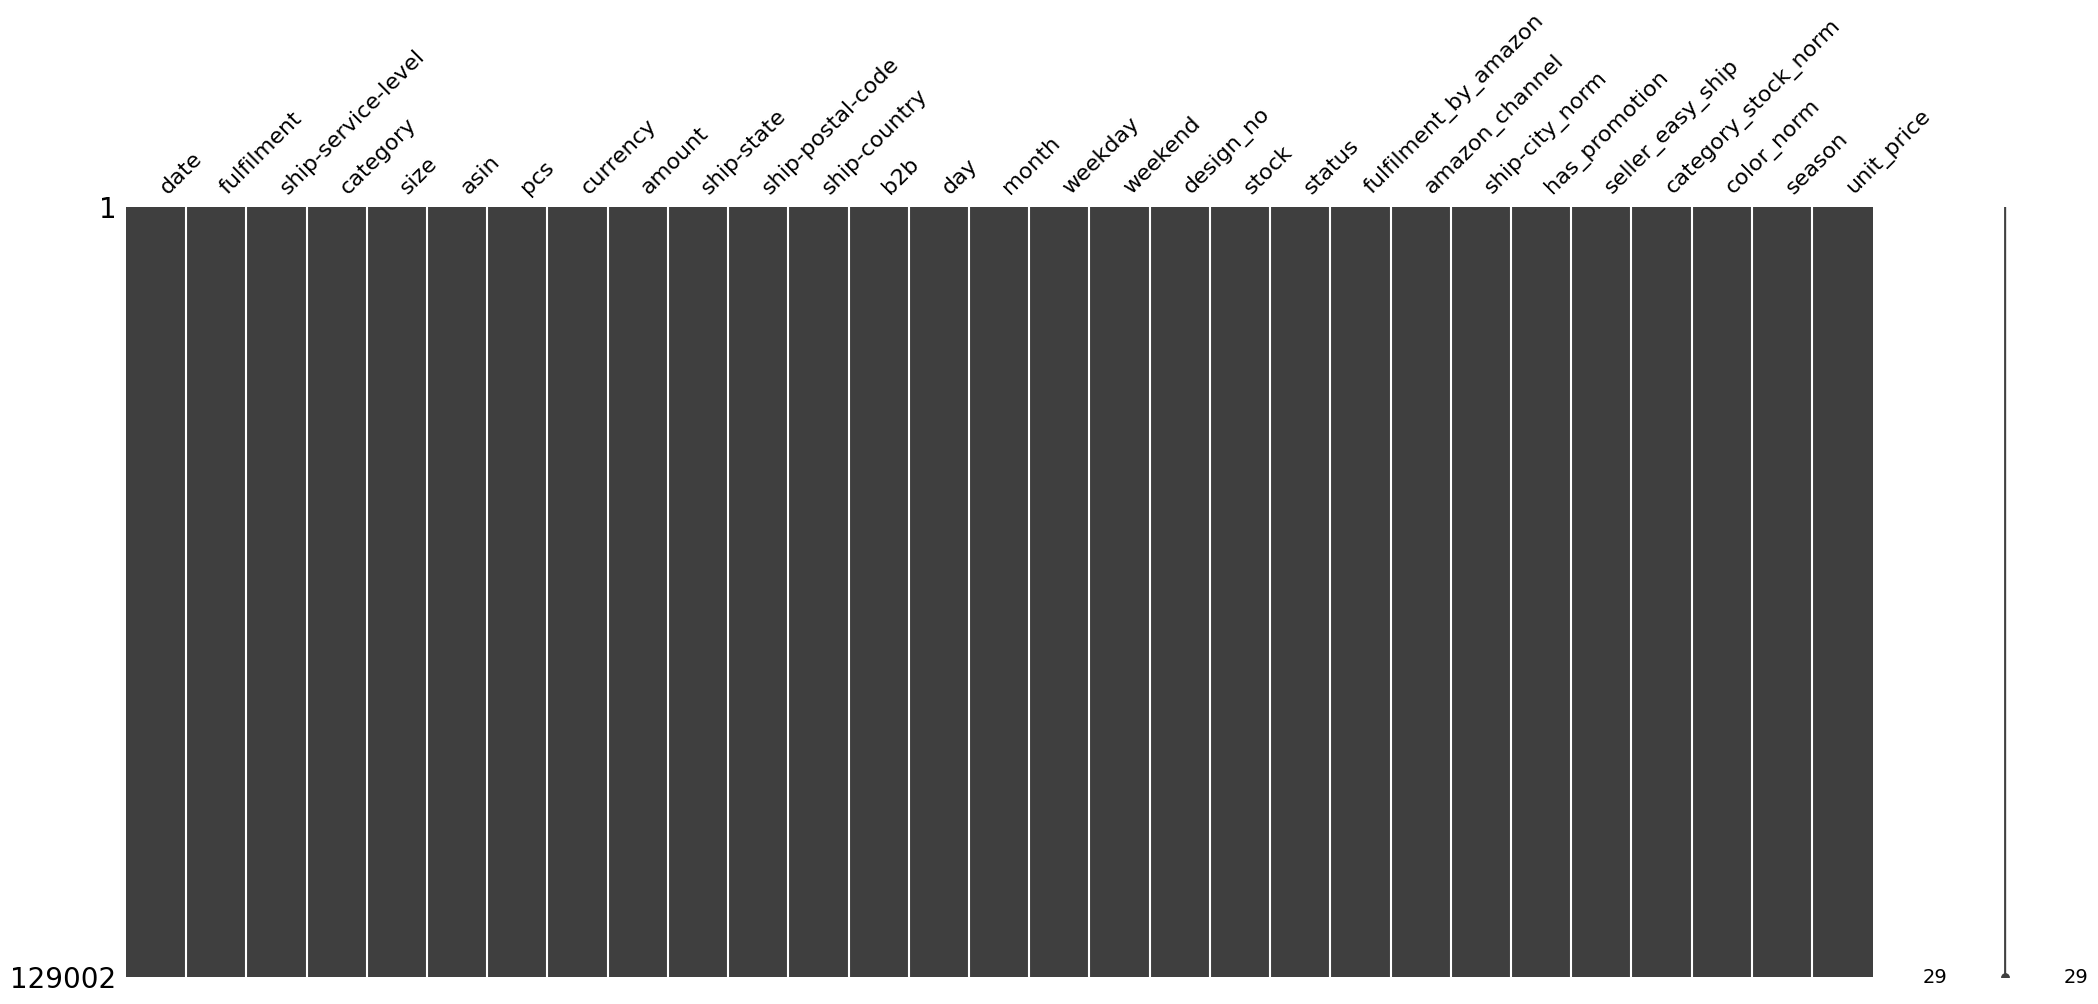

In [ ]:
msno.matrix(final_df)

In [ ]:
# Save cleaned data
final_df.to_pickle('final_df.ML3.3.pkl')